Using device: cuda  |  torch version: 2.8.0+cu126
Loaded dataset from: /content/bat-both.csv
Total rows: 129
Label distribution: {0: 65, 1: 64}
First sentence (baseball bat sense): During the storm, Jake grabbed the old baseball bat from the garage, using it to prop up the sagging porch roof until the wind died down.
Sense switch at row 65 (flying mammal): Made from polished maple, the new baseball bat felt light and powerful in her hands as she walked toward the on-deck circle.
Loaded bert-base-uncased. Hidden size: 768, num_hidden_layers: 12
Token id for 'bat': 7151
Extracting last-4 layer vectors for 'bat' tokens...
Successfully extracted vectors for 129/129 examples.
Feature set shapes:
          last: (129, 768)
  concat_last2: (129, 1536)
  concat_last3: (129, 2304)
  concat_last4: (129, 3072)
     avg_last2: (129, 768)
     avg_last3: (129, 768)
     avg_last4: (129, 768)

Clustering performance (higher is better):
       strategy       ARI       NMI  Homogeneity  Completeness  

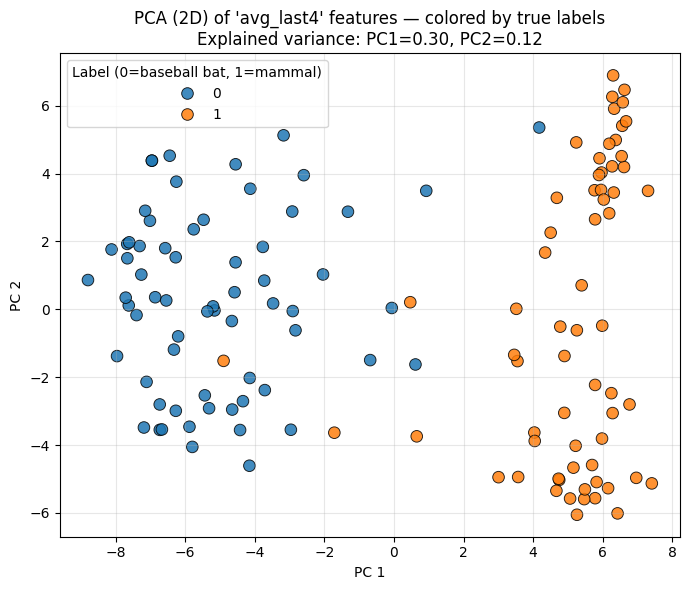


Top outliers (by distance to their assigned centroid):
#1: orig_idx=32 (line=33), dist=14.0614, true_label=0, pred_cluster=1, mapped_pred_label=0, misclustered=False
    Her argument struck with the precision of a well-swung baseball bat, shattering the flimsy defenses of his flawed logic into scattered fragments.
#2: orig_idx=121 (line=122), dist=13.4969, true_label=1, pred_cluster=0, mapped_pred_label=1, misclustered=False
    The vampire's cape fluttered like bat wings as he emerged from his coffin on Halloween night.
#3: orig_idx=61 (line=62), dist=11.5167, true_label=0, pred_cluster=1, mapped_pred_label=0, misclustered=False
    Based on consistent anecdotal reports of sales at sporting goods stores, and because of the Emerald ash borer epidemic, maple appears to be displacing ash as most popular new baseball bat material in the United States.
#4: orig_idx=2 (line=3), dist=10.9378, true_label=0, pred_cluster=1, mapped_pred_label=0, misclustered=False
    While hiking, Sarah reali

In [3]:
#@title Contextual embedding and Polysemy in BERT's 4 last layers

# ============================================
# 1) Setup (Install & Import Libraries)
# ============================================
!pip -q install transformers scikit-learn pandas matplotlib seaborn

import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizerFast, BertModel
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}  |  torch version: {torch.__version__}")

# ============================================
# 2) Data Loading and Preparation
# ============================================

# Attempt to load the CSV from common paths, without a header
csv_paths_to_try = [
    "/content/bat-both.csv",  # primary path per problem statement
]

df = None
for p in csv_paths_to_try:
    if os.path.exists(p):
        try:
            df = pd.read_csv(p, header=None, names=["sentence", "token_index", "char_span"])
            print(f"Loaded dataset from: {p}")
            break
        except Exception as e:
            print(f"Failed reading {p}: {e}")

if df is None:
    raise FileNotFoundError("Could not find /content/bat-both.csv or /content/both-bat.csv in this environment.")

# Ensure dtypes
df["sentence"] = df["sentence"].astype(str)
df["token_index"] = df["token_index"].astype(int)
df["char_span"] = df["char_span"].astype(str)

# Keep original (0-based) row indices for reporting outliers/prototypes
df["orig_idx"] = df.index

n_rows = len(df)
print(f"Total rows: {n_rows}")
if n_rows < 2:
    raise ValueError("Dataset appears too small.")

# Create integer labels: 0 for baseball bat (rows 0..64), 1 for flying mammal (rows 65..end)
labels = np.array([0 if i <= 64 else 1 for i in range(n_rows)], dtype=int)
df["label"] = labels

print("Label distribution:", pd.Series(labels).value_counts().to_dict())
print("First sentence (baseball bat sense):", df.iloc[0, 0])
if n_rows > 65:
    print("Sense switch at row 65 (flying mammal):", df.iloc[65, 0])

# ============================================
# 3) BERT Model and Tokenizer Loading
# ============================================
MODEL_NAME = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME).to(device)
model.eval()
print(f"Loaded {MODEL_NAME}. Hidden size: {model.config.hidden_size}, num_hidden_layers: {model.config.num_hidden_layers}")

# Token id for 'bat' (sanity check / fallback)
bat_token_id = tokenizer.convert_tokens_to_ids("bat")
print(f"Token id for 'bat': {bat_token_id}")

# ============================================
# 4) Representation Extraction
#    Strategy: Iterate in mini-batches; for each row extract the hidden states of the 'bat' token.
#    We request all hidden states but only keep the last 4 for efficiency.
# ============================================

def extract_last4_vectors_for_bat(
    sentences, token_indices, model, tokenizer, device, batch_size=16, max_length=128
):
    """
    Extract the last 4 hidden layer vectors for the 'bat' token per sentence using the provided token_index.
    Returns:
        last4_by_example: list of tuples per example: (layer12, layer11, layer10, layer9), each shape (768,)
        valid_mask: list of booleans indicating extraction success for each example
    """
    last4_by_example = []
    valid_mask = []

    assert len(sentences) == len(token_indices)

    for start in range(0, len(sentences), batch_size):
        end = start + batch_size
        batch_sents = sentences[start:end]
        batch_idx = token_indices[start:end]

        try:
            # Tokenize (pad to longest in batch; with truncation to avoid OOM)
            enc = tokenizer(
                batch_sents,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=max_length,
            )

            # Move tensors to device
            enc = {k: v.to(device) for k, v in enc.items()}
            input_ids = enc["input_ids"]
            attn = enc["attention_mask"]
            bsz, seq_len = input_ids.shape

            with torch.inference_mode():
                outputs = model(**enc, output_hidden_states=True)
                hidden_states = outputs.hidden_states  # tuple length 13: [embeds, layer1...layer12]

            for i in range(bsz):
                ti = int(batch_idx[i])
                # Actual sequence length via attention mask
                actual_len = int(attn[i].sum().item())

                # Validate token index; if invalid, try fallback by locating 'bat' token id
                if ti < 0 or ti >= actual_len:
                    candidate_positions = (input_ids[i][:actual_len] == bat_token_id).nonzero(as_tuple=True)[0]
                    if len(candidate_positions) > 0:
                        ti = int(candidate_positions[0].item())
                    else:
                        last4_by_example.append((None, None, None, None))
                        valid_mask.append(False)
                        continue

                try:
                    h12 = hidden_states[-1][i, ti, :].detach().float().cpu().numpy()
                    h11 = hidden_states[-2][i, ti, :].detach().float().cpu().numpy()
                    h10 = hidden_states[-3][i, ti, :].detach().float().cpu().numpy()
                    h09 = hidden_states[-4][i, ti, :].detach().float().cpu().numpy()
                    last4_by_example.append((h12, h11, h10, h09))
                    valid_mask.append(True)
                except Exception:
                    last4_by_example.append((None, None, None, None))
                    valid_mask.append(False)

            # Cleanup GPU memory
            del outputs, hidden_states, enc, input_ids, attn
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        except Exception as e:
            print(f"[WARN] Batch {start}:{end} failed with error: {e}. Falling back to per-example processing.")
            for sent, ti in zip(batch_sents, batch_idx):
                try:
                    enc = tokenizer(sent, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
                    enc = {k: v.to(device) for k, v in enc.items()}
                    with torch.inference_mode():
                        outputs = model(**enc, output_hidden_states=True)
                    hidden_states = outputs.hidden_states
                    input_ids = enc["input_ids"][0]
                    attn = enc["attention_mask"][0]
                    actual_len = int(attn.sum().item())

                    if ti < 0 or ti >= actual_len:
                        candidate_positions = (input_ids[:actual_len] == bat_token_id).nonzero(as_tuple=True)[0]
                        if len(candidate_positions) > 0:
                            ti = int(candidate_positions[0].item())
                        else:
                            last4_by_example.append((None, None, None, None))
                            valid_mask.append(False)
                            continue

                    h12 = hidden_states[-1][0, ti, :].detach().float().cpu().numpy()
                    h11 = hidden_states[-2][0, ti, :].detach().float().cpu().numpy()
                    h10 = hidden_states[-3][0, ti, :].detach().float().cpu().numpy()
                    h09 = hidden_states[-4][0, ti, :].detach().float().cpu().numpy()
                    last4_by_example.append((h12, h11, h10, h09))
                    valid_mask.append(True)

                    del outputs, hidden_states, enc, input_ids, attn
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()

                except Exception:
                    last4_by_example.append((None, None, None, None))
                    valid_mask.append(False)

    return last4_by_example, valid_mask

# Extract last-4 layer vectors for all sentences using their token_index
sentences = df["sentence"].tolist()
token_indices = df["token_index"].tolist()

print("Extracting last-4 layer vectors for 'bat' tokens...")
last4_by_example, valid_mask = extract_last4_vectors_for_bat(
    sentences, token_indices, model, tokenizer, device, batch_size=16, max_length=128
)

valid_count = sum(valid_mask)
print(f"Successfully extracted vectors for {valid_count}/{len(sentences)} examples.")

# Filter out invalid rows if any (ideally zero)
if valid_count != len(sentences):
    print("[WARN] Some rows failed vector extraction; filtering them out.")
    df_valid = df[valid_mask].reset_index(drop=True)
    last4_by_example = [v for v, ok in zip(last4_by_example, valid_mask) if ok]
else:
    df_valid = df.copy()

labels_valid = df_valid["label"].to_numpy().astype(int)

# ============================================
# 5) Representation Strategy Selection
#    Build feature matrices for:
#    - Strategy 1: Last layer only
#    - Strategy 2: Concatenation of last N layers (N=2,3,4)
#    - Strategy 3: Averaging of last N layers (N=2,3,4)
# ============================================

def build_feature_sets(last4):
    """
    last4: list of tuples per example: (h12, h11, h10, h09)
    Returns a dict of feature_name -> np.ndarray (n_examples, dim)
    """
    features = {}
    h12_list = [t[0] for t in last4]
    h11_list = [t[1] for t in last4]
    h10_list = [t[2] for t in last4]
    h09_list = [t[3] for t in last4]

    # Strategy 1: Last layer only
    features["last"] = np.stack(h12_list, axis=0)

    # Strategy 2: Concatenation of last N layers
    features["concat_last2"] = np.concatenate(
        [np.stack(h12_list), np.stack(h11_list)], axis=1
    )
    features["concat_last3"] = np.concatenate(
        [np.stack(h12_list), np.stack(h11_list), np.stack(h10_list)], axis=1
    )
    features["concat_last4"] = np.concatenate(
        [np.stack(h12_list), np.stack(h11_list), np.stack(h10_list), np.stack(h09_list)], axis=1
    )

    # Strategy 3: Averaging of last N layers
    features["avg_last2"] = (np.stack(h12_list) + np.stack(h11_list)) / 2.0
    features["avg_last3"] = (np.stack(h12_list) + np.stack(h11_list) + np.stack(h10_list)) / 3.0
    features["avg_last4"] = (np.stack(h12_list) + np.stack(h11_list) + np.stack(h10_list) + np.stack(h09_list)) / 4.0

    return features

features_dict = build_feature_sets(last4_by_example)

print("Feature set shapes:")
for k, v in features_dict.items():
    print(f"  {k:>12s}: {v.shape}")

# ============================================
# 6) Clustering and Evaluation
#    For each feature strategy, run KMeans (k=2)
#    and compute ARI, NMI, Homogeneity, Completeness.
# ============================================

def evaluate_strategies(features_dict, labels, random_state=SEED):
    results = []
    for name, X in features_dict.items():
        kmeans = KMeans(n_clusters=2, random_state=random_state, n_init=50)
        preds = kmeans.fit_predict(X)

        ari = adjusted_rand_score(labels, preds)
        nmi = normalized_mutual_info_score(labels, preds)
        hom = homogeneity_score(labels, preds)
        cmp = completeness_score(labels, preds)

        results.append({
            "strategy": name,
            "ARI": ari,
            "NMI": nmi,
            "Homogeneity": hom,
            "Completeness": cmp,
            "dim": X.shape[1],
        })
    results_df = pd.DataFrame(results).sort_values(by=["ARI", "NMI"], ascending=False).reset_index(drop=True)
    return results_df

results_df = evaluate_strategies(features_dict, labels_valid)
print("\nClustering performance (higher is better):")
print(results_df)

# ============================================
# 7) Present the best feature extraction strategy
# ============================================
best_strategy = results_df.iloc[0]["strategy"]
best_ari = results_df.iloc[0]["ARI"]
best_nmi = results_df.iloc[0]["NMI"]
best_dim = int(results_df.iloc[0]["dim"])

print(f"\nBest strategy: {best_strategy}  (dim={best_dim})")
print(f"  ARI: {best_ari:.4f} | NMI: {best_nmi:.4f}")

# ============================================
# 8) Visualization (Optional)
#    PCA to 2D for the best performing embedding strategy
#    Scatter plot colored by true labels (0/1)
# ============================================
DO_PLOT = True
X_best = features_dict[best_strategy]
y_true = labels_valid

if DO_PLOT:
    pca = PCA(n_components=2, random_state=SEED)
    X_2d = pca.fit_transform(X_best)

    plt.figure(figsize=(7, 6))
    sns.scatterplot(
        x=X_2d[:, 0], y=X_2d[:, 1],
        hue=y_true,
        palette={0: "tab:blue", 1: "tab:orange"},
        alpha=0.85, edgecolor="k", s=70
    )
    plt.title(f"PCA (2D) of '{best_strategy}' features — colored by true labels\n"
              f"Explained variance: PC1={pca.explained_variance_ratio_[0]:.2f}, PC2={pca.explained_variance_ratio_[1]:.2f}")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.legend(title="Label (0=baseball bat, 1=mammal)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ============================================
# 9) Outlier Retrieval (Top-5 by distance to assigned centroid)
#    - Fit KMeans on best features (again) to get preds and centers.
#    - Compute distance of each point to its assigned centroid.
#    - Report the 5 strongest outliers (largest distances).
#    - Also report whether each outlier is misclustered after aligning cluster IDs to labels.
# ============================================

kmeans_best = KMeans(n_clusters=2, random_state=SEED, n_init=50)
preds_best = kmeans_best.fit_predict(X_best)
centers = kmeans_best.cluster_centers_

# Distances to assigned centroid (Euclidean)
dists = np.linalg.norm(X_best - centers[preds_best], axis=1)

df_result = df_valid.copy()
df_result["pred_cluster"] = preds_best
df_result["dist_to_center"] = dists

# Align cluster IDs to true labels via majority vote (for interpretability)
cluster_to_label_map = {}
for c in range(2):
    mask = (preds_best == c)
    if mask.sum() == 0:
        cluster_to_label_map[c] = 0  # fallback
    else:
        counts = np.bincount(y_true[mask], minlength=2)
        cluster_to_label_map[c] = int(np.argmax(counts))

mapped_preds = np.vectorize(cluster_to_label_map.get)(preds_best)
misclustered_mask = (mapped_preds != y_true)
df_result["mapped_pred_label"] = mapped_preds
df_result["misclustered"] = misclustered_mask

# Pick top-5 outliers by largest distance
TOP_K = 5
order_desc = np.argsort(-dists)
topk_idx = order_desc[: min(TOP_K, len(df_result))]

print("\nTop outliers (by distance to their assigned centroid):")
for rank, i in enumerate(topk_idx, start=1):
    row = df_result.iloc[i]
    orig0 = int(row["orig_idx"])                 # 0-based row id in original CSV
    orig1 = orig0 + 1                            # 1-based line number
    sent = row["sentence"]
    true_lbl = int(row["label"])
    pred_c = int(row["pred_cluster"])
    mapped_lbl = int(row["mapped_pred_label"])
    dist = float(row["dist_to_center"])
    mis = bool(row["misclustered"])
    print(f"#{rank}: orig_idx={orig0} (line={orig1}), dist={dist:.4f}, "
          f"true_label={true_lbl}, pred_cluster={pred_c}, mapped_pred_label={mapped_lbl}, misclustered={mis}")
    print(f"    {sent}")

# ============================================
# 10) Cluster Prototypes (closest sentences to each cluster centroid)
#     - For each cluster, report the two sentences closest to its center.
# ============================================

print("\nCluster prototypes (two sentences closest to each centroid):")
for c in range(2):
    idxs_c = np.where(preds_best == c)[0]
    if len(idxs_c) == 0:
        print(f"Cluster {c}: empty")
        continue

    # Distances to this cluster's centroid
    dists_c = np.linalg.norm(X_best[idxs_c] - centers[c], axis=1)
    nearest_order = np.argsort(dists_c)  # ascending
    top2_local = nearest_order[: min(2, len(idxs_c))]
    top2_global_idx = idxs_c[top2_local]

    # Interpret this cluster's majority label (sense)
    majority_label = cluster_to_label_map[c]
    majority_label_name = "baseball bat (0)" if majority_label == 0 else "flying mammal (1)"

    print(f"\nCluster {c} (majority label: {majority_label_name}) — closest sentences to centroid:")
    for j, gidx in enumerate(top2_global_idx, start=1):
        row = df_result.iloc[gidx]
        orig0 = int(row["orig_idx"])
        orig1 = orig0 + 1
        true_lbl = int(row["label"])
        dist = float(np.linalg.norm(X_best[gidx] - centers[c]))
        print(f"  [{j}] orig_idx={orig0} (line={orig1}), true_label={true_lbl}, dist={dist:.4f}")
        print(f"      {row['sentence']}")

# Cleanup GPU memory
del model
if torch.cuda.is_available():
    torch.cuda.empty_cache()